# Can't seem to find PSBs in Yirui's SIMBA simulated SFHs, opting for making my own using the parametric forumla in Wild2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

from george import kernels
import george
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

from scipy.optimize import minimize
import pickle

Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.
running without emcee


### First define the functions related to GP fitting

In [3]:
def nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

def gp_interpolator(x,y,res = 1000, Nparam = 3, decouple_sfr = False, var=False, sample=False):

    yerr = np.zeros_like(y)
    yerr[2:(2+Nparam)] = 0.001/np.sqrt(Nparam)
    if len(yerr) > 26:
        yerr[2:(2+Nparam)] = 0.1/np.sqrt(Nparam)
    yerr[(2+Nparam):] = 0.1
    #kernel = np.var(y) * kernels.ExpSquaredKernel(np.median(y))
    #kernel = np.var(y) * kernels.LinearKernel(np.median(y),order=1)
    #kernel = np.var(y) * kernels.Matern32Kernel(np.median(y)) #+ k2
    kernel = np.var(y) * (kernels.Matern32Kernel(np.median(y)) + kernels.LinearKernel(np.median(y), order=2))
    gp = george.GP(kernel, solver=george.HODLRSolver)

    #print(xax.shape, yerr.shape)
    #gp.compute(x.ravel(), yerr.ravel())
    # the choices of yerr in dense_basis seems arbituary, switching them off for now
    gp.compute(x.ravel())
    
    # optimize kernel parameters
    #p0 = gp.get_parameter_vector()
    #results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", args = (gp, y))
    #print(results)
    #gp.set_parameter_vector(results.x)

    x_pred = np.linspace(np.amin(x), np.amax(x), res)
    y_pred, pred_var = gp.predict(y.ravel(), x_pred, return_var=True)
    
    if var==True:
        if sample==True:
            samples = gp.sample_conditional(y.ravel(), x_pred, size=30)
            return x_pred, y_pred, pred_var, samples
        else:
            return x_pred, y_pred, pred_var
    else:
        return x_pred, y_pred

def treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
              decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=None):
    sfh = (np.diff(mass_arr_interp)*10**(sfh_tuple[0])) / (np.diff(time_arr_interp)*cosmo.age(zval).value*1e9)
    #sfh_scale = 10**(sfh_tuple[0])/(cosmo.age(zval).value*1e9/1000)
    #sfh = np.diff(mass_arr_interp)*sfh_scale
    sfh[sfh<0] = 0
    sfh = np.insert(sfh,0,[0])
    if pred_var is not None:
        sfh_var = (pred_var[1:]+pred_var[:-1]) * (10**(sfh_tuple[0])/(np.diff(time_arr_interp)*cosmo.age(zval).value*1e9))**2
        sfh_var = np.insert(sfh_var,0,[0])
    
    sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
    if sfr_decouple_time_index == 0:
        sfr_decouple_time_index = 2
    mass_lastbins = np.trapz(x=time_arr_interp[-sfr_decouple_time_index:]*1e9*(cosmo.age(zval).value), y=sfh[-sfr_decouple_time_index:])
    mass_remaining = 10**(sfh_tuple[0]) - mass_lastbins
    if mass_remaining < 0:
        mass_remaining = 0
        print('input SFR, M* combination is not physically consistent (log M*: %.2f, log SFR: %.2f.)' %(sfh_tuple[0],sfh_tuple[1]))
    mass_initbins = np.trapz(x=time_arr_interp[0:(1000-sfr_decouple_time_index)]*1e9*(cosmo.age(zval).value), y=sfh[0:(1000-sfr_decouple_time_index)])
    sfh[0:(1000-sfr_decouple_time_index)] = sfh[0:(1000-sfr_decouple_time_index)] * mass_remaining / mass_initbins
    
    if (np.abs(np.log10(sfh[-1]) - sfh_tuple[1]) > sfr_tolerance) or (decouple_sfr == True):
        sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    
#     if decouple_sfr == True:
#         sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
#         sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    if pred_var is not None:
        return sfh, sfh_var
    else: return sfh
    
#iyer binning's GP fit function
def tuple_to_sfh(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # generate an SFH from an input tuple (Mass, SFR, {tx}) at a specified redshift


    Nparam = int(sfh_tuple[2])
    mass_quantiles = np.linspace(0,1,Nparam+2)
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = sfh_tuple[3:]
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)

    # now add SFR constraints

    # SFR smoothly increasing from 0 at the big bang
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])

    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=True)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append([sfh_i, sample])

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

#log time binning's GP fit function
def fit_logtime(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, 
                decouple_sfr_time = 10, sfr_tolerance = 0.05, vb = False,cosmo = cosmo):
    # sfh_tuple[0] = total mass formed in log10 form
    # sfh_tuple[1] = log10 SFR at time of observation
    # sfh_tuple[2] = list of time bin boundaries in fractions of the universe's current
    # sfh_tuple[3] = list of fraction mass formed at bin boundaries
    
    # generate an SFH from an input tuple at a specified redshift
    Nparam = int(sfh_tuple[2])
    input_tx = sfh_tuple[3:3+Nparam]
    input_mf = sfh_tuple[3+Nparam:3+2*Nparam]
    c_mass_formed = np.zeros(len(input_mf))
    for i,mi in enumerate(input_mf):
        c_mass_formed[i] = np.sum(input_mf[:i+1])
    mass_quantiles = np.array([0,*c_mass_formed,1])
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = input_tx
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)
    
    # now add SFR constraints
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])
    
    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    #debug stuff
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
        plt.plot(model_ages, c_model_sfh)
        plt.plot(time_quantiles*age_at_z, mass_quantiles*np.trapz(y=model_sfh, x=model_ages))
        plt.show()
        
    #transform 0-1 in linear tme to 0-1 in log lookback time
    #a = 1
    #time_quantiles_ = 1-np.log(a*((1-time_quantiles)+1)-(a-1))/np.log(a+1)
    #print(time_quantiles)
    #print(time_quantiles_)
    #time_quantiles = time_quantiles_.copy()
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=True)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
        
    #time_arr_interp_ = 1-((np.exp((1-time_arr_interp)*np.log(a+1))+(a-1))/a-1)
    #print(time_arr_interp)
    #print(time_arr_interp_)
    #time_arr_interp = time_arr_interp_.copy()
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append([sfh_i, sample])

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

### Next, define the functions used for binning and running the fits

In [5]:
def bin_iyer(Nbins, end_time=None):
    if end_time is not None:
        end_age = age_at_z-end_time*10**-9
        model_ages_ = model_ages[model_ages>=end_age].copy()
        model_sfh_ = model_sfh[model_ages>=end_age].copy()
    else:
        model_ages_ = model_ages.copy()
        model_sfh_ = model_sfh.copy()
    total_mass = np.trapz(y=model_sfh_, x=model_ages_)
    c_mass = []
    for i,sfh in enumerate(model_sfh_):
        c_mass.append(np.trapz(y=model_sfh_[:i+1], x=model_ages_[:i+1])/total_mass)
    mass_percentiles = np.arange(1,Nbins)*1/Nbins
    tx = np.interp(mass_percentiles, c_mass, model_ages_/age_at_z)
    return np.array(tx)

def cal_ave_sfr(age,sfh,tx,age_at_z,abs_err=False,isfit=False):
    sort_ind = np.argsort(age)
    age = age[sort_ind]
    sfh = sfh[sort_ind]
    tx_ = np.array([0, *tx, 1])*age_at_z
    ave_sfr = np.zeros(len(tx)+1)
    for i,txi in enumerate(tx_):
        if i>0:
            this_age = age[np.where((age>tx_[i-1]) & (age<txi))]
            this_age = [tx_[i-1], *this_age, txi]
            this_sfh = sfh[np.where((age>tx_[i-1]) & (age<txi))]
            this_sfh = [np.interp(tx_[i-1], age, sfh), *this_sfh, np.interp(txi, age, sfh)]
            ave_sfr[i-1] = np.trapz(y=this_sfh, x=this_age) / (this_age[-1]-this_age[0])
    if abs_err == False:
        return ave_sfr, tx_[:-1], tx_[1:]
    elif abs_err == True:
        if isfit==False:
            age_ = age.copy()
            sfh_ = sfh.copy()
        elif isfit==True:
            age_ = model_ages
            sfh_ = model_sfh
        ave_sfh = np.zeros(len(age_))
        for i,txi in enumerate(tx_):
            if i>0:
                ave_sfh[np.where((age_>tx_[i-1]) & (age_<txi))] = ave_sfr[i-1]
        Mstar = np.trapz(y=sfh_, x=age_)
        ave_sfr_value = Mstar/max(age_)
        abs_err_value = np.trapz(y=((sfh_-ave_sfh)**2),x=age_)/(Mstar*ave_sfr_value)
        return ave_sfr, tx_[:-1], tx_[1:], abs_err_value
    
def bin_logtime(Nbins, interp=True, begin_time=3*10**8, end_time=None):
    # begin_time and end_time are the two extremes at which the bin boundaries are linspaced between
    # Note that they are in lookback time instead of age
    if end_time == None:
        end_time = age_at_z*10**9
    logtime_per_bin = (np.log10(end_time)-np.log10(begin_time))/(Nbins-1)
    tx = age_at_z - 10**(np.arange(Nbins-1)*logtime_per_bin + np.log10(begin_time) - 9)
    tx = tx[::-1]
    
    mass_so_far = [0]
    for txi in tx:
        if interp==True:
            sfh_at_txi = np.interp(txi, model_ages, model_sfh)
            insert_index = model_ages.searchsorted(txi)
            model_ages_ = np.insert(model_ages,insert_index,txi)
            model_sfh_ = np.insert(model_sfh,insert_index,sfh_at_txi)
            int_mass = np.trapz(y=model_sfh_[model_ages_<=txi], x=model_ages_[model_ages_<=txi]*10**9)
        else:
            int_mass = np.trapz(y=model_sfh[model_ages<=txi], x=model_ages[model_ages<=txi]*10**9)
        mass_so_far.append(int_mass)
    #mass_so_far.append(np.trapz(y=model_sfh, x=model_ages*10**9))
    mass_so_far = np.array(mass_so_far)
    mass_formed = mass_so_far[1:]-mass_so_far[:-1]
    t_mass_formed = np.trapz(y=model_sfh, x=model_ages*10**9)
    return tx/age_at_z, mass_formed/t_mass_formed

def db_fit(Nbins, tx):
    iyer_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx])
    return tuple_to_sfh(iyer_param, 0.00, vb=False)

def lt_fit(Nbins, tx, mf):
    lt_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx, mf])
    return fit_logtime(lt_param, 0.00, vb=False)

### Now generate the PSB SFHs

0.13819926785068684
0.4002758286384226
0.45964729185065833
0.39820687796746457
0.3418222686085405
0.1611500688647028
0.19172869493099057
0.12926884580380246
0.3857751376402726
0.41424117655121884
0.2631863524840009
0.14129108163782123
0.19723408319073302
0.24747651309243268
0.42872169843628594
0.22630040985858338
0.37979976095628143
0.11393827173405398
0.10355545786155883
0.3181169278106818


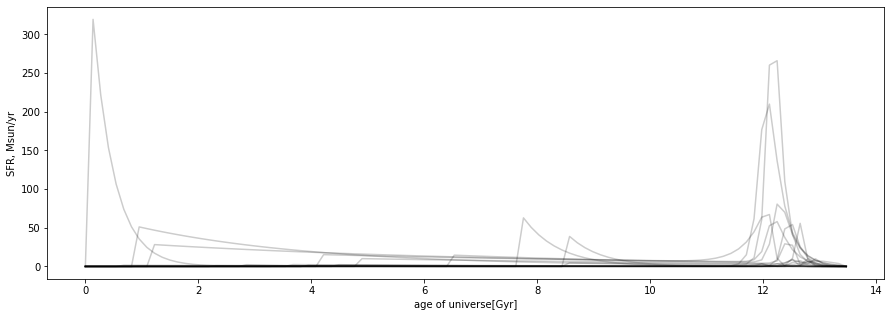

In [113]:
#fburst = 0.1-0.5
#tburst = -0.5 - -1.5
#alpha = 30-300
#beta = 30-300
#tform = 0-10
#tau = 0.3-10
#logM = 9-11.5

def dpl(t, t_burst, strength, alpha=450, beta=250):
    return strength/((t/t_burst)**alpha + (t/t_burst)**-beta)

def exp_decay(t, t_form, tau):
    result = np.exp(-(t-t_form)/tau)
    result[t<t_form] = 0
    return result

def psb2(t, t_form, tau, t_burst, alpha, beta, fburst):
    t = t*10**9
    age = t_form*10**9
    tau = tau*10**9
    burstage = t_burst*10**9
    alpha = alpha
    beta = beta
    fburst = fburst
    sfr = np.zeros(len(t))
    age_at_z_ = age_at_z*10**9

    ind = (np.where((t > age) & (t < burstage)))[0]
    texp = t[ind] - age
    sfr_exp = np.exp(-texp/tau) 
    sfr_exp_tot = np.sum(sfr_exp*(t[1]-t[0]))

    mask = t < age_at_z_
    tburst = t[mask]
    tau_plaw = burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*(t[1]-t[0]))

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot
    sfr[mask] += fburst * (((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1) / sfr_burst_tot
    
    return sfr

z = 0.00
age_at_z = cosmo.age(z).value
model_ages = np.linspace(0,age_at_z, 100)
SFHs = []
Mstars = []
for i in range(20):
    fburst = np.random.uniform(low=0.1, high=0.5)
    tburst = np.random.uniform(low=age_at_z-1.5, high=age_at_z-0.5)
    alpha = np.random.uniform(low=30, high=300)
    beta = np.random.uniform(low=30, high=300)
    tform = np.random.uniform(low=0, high=age_at_z-4)
    tau = np.random.uniform(low=0.3, high=10)
    logM = np.random.uniform(low=9, high=11.5)
    SFHs.append(10**logM*psb2(model_ages, tform, tau, tburst, alpha, beta, fburst))
    Mstars.append(10**logM)
    print(fburst)
fig, ax = plt.subplots(figsize=[15,5])
for i in SFHs:
    plt.plot(model_ages, i, 'k', alpha=0.2)
#ax.set_yscale("log")
#ax.set_xscale('log')
ax.set_xlabel("age of universe[Gyr]")
ax.set_ylabel("SFR, Msun/yr")
#ax.set_xlim(-1,14)
plt.show()

In [106]:
model_sfh = SFHs[np.random.randint(20)]
model_Mstar = np.trapz(y=model_sfh, x=model_ages)*10**9

#cumulative mass formed vs age
Mstar_total_model = np.trapz(model_sfh, x=model_ages)
c_model_sfh = np.zeros(len(model_sfh))
for i,sfh in enumerate(model_sfh):
    c_model_sfh[i] = np.trapz(model_sfh[:i+1],x=model_ages[:i+1])/Mstar_total_model

summed squared arror between averaged sfr and actual sfh = 1.536269173294177


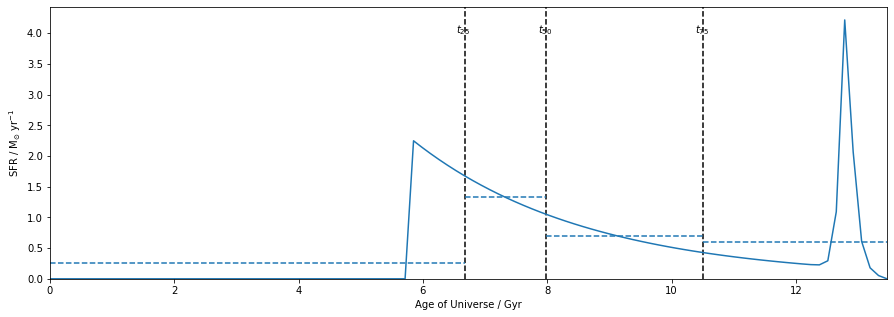

In [107]:
Nbins = 4
tx = bin_iyer(Nbins)

fig, ax = plt.subplots(figsize=[15,5])
p0 = ax.plot(model_ages, model_sfh)
ax.set_xlim([0,age_at_z])
ax.set_xlabel('Age of Universe / Gyr')
ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
ylims = ax.get_ylim()
ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
for i,txi in enumerate(tx):
    ax.annotate('$t_{'+str(int((i+1)*100/Nbins))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
ave_sfr = ave_sfr_[:-1]
print('summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
ax.hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin')
ax.set_ylim([0,ylims[1]])
plt.show()

(fitted) summed squared arror between averaged sfr and actual sfh = 1.5363158994880586


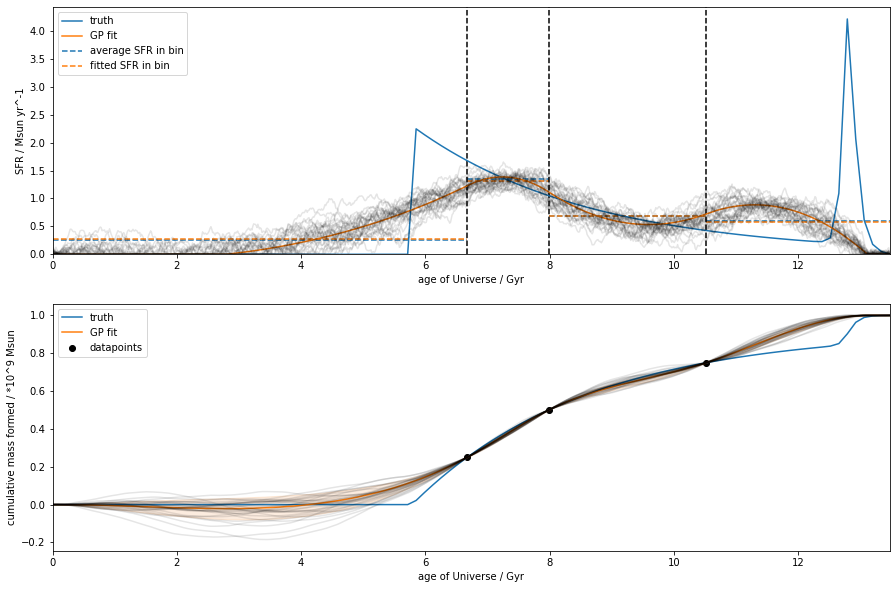

In [108]:
iyer_sfh, iyer_ages, iyer_c_mass, iyer_sfh_var, iyer_c_mass_var, iyer_samples = db_fit(Nbins, tx)
iyer_ave_sfr_ = cal_ave_sfr(iyer_ages, iyer_sfh, tx, age_at_z, abs_err=True, isfit=True)
iyer_ave_sfr = iyer_ave_sfr_[:-1]
print('(fitted) summed squared arror between averaged sfr and actual sfh =', iyer_ave_sfr_[-1])

fig, ax = plt.subplots(2, 1, figsize=[15,10])
p0 = ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
p1 = ax[0].plot(iyer_ages, iyer_sfh, label='GP fit')
ax[0].hlines(*iyer_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)
#ax[0].fill_between(iyer_ages, iyer_sfh-np.sqrt(iyer_sfh_var), iyer_sfh+np.sqrt(iyer_sfh_var), 
#                  color='sandybrown', alpha=0.2)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0,ylims[1]])
ax[0].set_xlabel('age of Universe / Gyr')
ax[0].set_ylabel('SFR / Msun yr^-1')
ax[0].legend()

ax[1].plot(model_ages, c_model_sfh, label='truth')
ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', label='datapoints')
ax[1].plot(iyer_ages, iyer_c_mass, label='GP fit')
ax[1].fill_between(iyer_ages, iyer_c_mass-np.sqrt(iyer_c_mass_var), iyer_c_mass+np.sqrt(iyer_c_mass_var), 
                  color='sandybrown', alpha=0.2)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
for samp in iyer_samples:
    ax[0].plot(iyer_ages, samp[0], color='k', alpha=0.1)
    ax[1].plot(iyer_ages, samp[1], color='k', alpha=0.1)
ax[1].legend()
plt.show()

In [109]:
def plot_sfh(ax, ylims):
    ax[0].set_xlim([0,age_at_z])
    ax[0].set_ylim([0,ylims[1]])
    ax[0].set_xlabel('age of Universe / Gyr')
    ax[0].set_ylabel('SFR / Msun yr^-1')
    ax[0].legend()
    
    ax[1].set_xlim([0,age_at_z])
    ax[1].set_xlabel('age of Universe / Gyr')
    ax[1].set_ylabel('cumulative mass formed / *10^9 Msun')
    ax[1].legend()
    return ax

def do_iyer_fitting(Nbins, vb=True):
    if vb == True:
        print(f'Iyer-only binning and fitting for {Nbins} bins.')
    tx = bin_iyer(Nbins)
    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    if vb == True:
        print('(binning) summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
    
    iyer_sfh, iyer_ages, iyer_c_mass, iyer_sfh_var, iyer_c_mass_var, iyer_samples = db_fit(Nbins, tx)
    iyer_ave_sfr_ = cal_ave_sfr(iyer_ages, iyer_sfh, tx, age_at_z, abs_err=True, isfit=True)
    iyer_ave_sfr = iyer_ave_sfr_[:-1]
    if vb == True:
        print('(fitted) summed squared arror between averaged sfr and actual sfh =', iyer_ave_sfr_[-1])

    if vb == True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
        ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
        p1 = ax[0].plot(iyer_ages, iyer_sfh, label='GP fit')
        ax[0].hlines(*iyer_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)

        ax[1].plot(model_ages, c_model_sfh, label='truth')
        ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', label='datapoints')
        ax[1].plot(iyer_ages, iyer_c_mass, label='GP fit')
        ax[1].fill_between(iyer_ages, iyer_c_mass-np.sqrt(iyer_c_mass_var), iyer_c_mass+np.sqrt(iyer_c_mass_var), 
                          color='sandybrown', alpha=0.2)
        for samp in iyer_samples:
            ax[0].plot(iyer_ages, samp[0], color='k', alpha=0.1)
            ax[1].plot(iyer_ages, samp[1], color='k', alpha=0.1)

        ax = plot_sfh(ax, ylims)
        plt.show()
    
    return ave_sfr_[-1], iyer_ave_sfr_[-1]
    
def do_lt_fitting(Nbins, vb=True):
    if vb == True:
        print(f'Log-time-only binning and fitting for {Nbins} bins.')
    tx, f_mass_formed = bin_logtime(Nbins, interp=True, end_time=None)
    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    if vb == True:
        print('(binning) summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
    
    lt_sfh, lt_ages, lt_c_mass, lt_sfh_var, lt_c_mass_var, lt_samples = lt_fit(Nbins, tx, f_mass_formed)
    lt_ave_sfr_ = cal_ave_sfr(lt_ages, lt_sfh, tx, age_at_z, abs_err=True, isfit=True)
    lt_ave_sfr = lt_ave_sfr_[:-1]
    if vb == True:
        print('(fitted) summed squared arror between averaged sfr and actual sfh =', lt_ave_sfr_[-1])

    if vb == True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
        ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
        p1 = ax[0].plot(lt_ages, lt_sfh, label='GP fit')
        ax[0].hlines(*lt_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)

        ax[1].plot(model_ages, c_model_sfh, label='truth')
        ax[1].scatter(tx*age_at_z, np.cumsum(f_mass_formed), color='k', marker='x', label='datapoints')
        ax[1].plot(lt_ages, lt_c_mass, label='GP fit')
        ax[1].fill_between(lt_ages, lt_c_mass-np.sqrt(lt_c_mass_var), lt_c_mass+np.sqrt(lt_c_mass_var), 
                          color='sandybrown', alpha=0.2)
        for samp in lt_samples:
            ax[0].plot(lt_ages, samp[0], color='k', alpha=0.1)
            ax[1].plot(lt_ages, samp[1], color='k', alpha=0.1)

        ax = plot_sfh(ax, ylims)
        plt.show()
        
    return ave_sfr_[-1], lt_ave_sfr_[-1]
    
def do_iyer_lt_fitting(Nbins, vb=True):
    if vb == True:
        print(f'Iyer-then-log-time binning and fitting for {Nbins[0]} and then {Nbins[1]} bins.')
    tx_iyer = bin_iyer(Nbins[0])
    tx_lt, mf_lt = bin_logtime(Nbins[1], end_time=(1-tx_iyer[-1])*age_at_z*10**9)

    #converting dense_basis info into log time info
    c_mf_iyer = np.arange(1,Nbins[0])/Nbins[0]
    c_mf_lt = np.cumsum(mf_lt)
    c_mf = np.concatenate((c_mf_iyer, c_mf_lt))
    tx = np.concatenate((tx_iyer, tx_lt))
    sort_ind = np.argsort(tx)
    tx = tx[sort_ind]
    c_mf = np.insert(c_mf[sort_ind],0,0)
    mf = c_mf[1:]-c_mf[:-1]

    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    if vb == True:
        print('(binning) summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
    
    combine_sfh, combine_ages, combine_c_mass, combine_sfh_var, combine_c_mass_var, combine_samples = lt_fit(np.sum(Nbins)-1, tx, mf)
    combine_ave_sfr_ = cal_ave_sfr(combine_ages, combine_sfh, tx, age_at_z, abs_err=True, isfit=True)
    combine_ave_sfr = combine_ave_sfr_[:-1]
    if vb == True:
        print('(fitted) summed squared arror between averaged sfr and actual sfh =', combine_ave_sfr_[-1])

    if vb == True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        ax[0].vlines(tx_iyer*age_at_z, 0, ylims[1], color='k', ls='--', label='iyer2019 boundaries')
        ax[0].vlines(tx_lt*age_at_z, 0, ylims[1], color='k', ls=':', label='log time boundaries')
        ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
        p1 = ax[0].plot(combine_ages, combine_sfh, label='GP fit')
        ax[0].hlines(*combine_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)

        ax[1].plot(model_ages, c_model_sfh, label='truth')
        ax[1].scatter(tx_iyer*age_at_z, np.linspace(0,1,Nbins[0]+1)[1:-1], color='k', label='iyer datapoints')
        ax[1].scatter(tx_lt*age_at_z, c_mf_lt, color='k', marker='x', label='logtime datapoints')
        ax[1].plot(combine_ages, combine_c_mass, label='GP fit')
        ax[1].fill_between(combine_ages, combine_c_mass-np.sqrt(combine_c_mass_var), combine_c_mass+np.sqrt(combine_c_mass_var), 
                          color='sandybrown', alpha=0.2)
        for samp in combine_samples:
            ax[0].plot(combine_ages, samp[0], color='k', alpha=0.03)
            ax[1].plot(combine_ages, samp[1], color='k', alpha=0.03)

        ax = plot_sfh(ax, ylims)
        plt.show()
        
    return ave_sfr_[-1], combine_ave_sfr_[-1]
    
def do_iyer_iyer_fitting(Nbins, vb=True):
    if vb == True:
        print(f'Iyer-then-log-time binning and fitting for {Nbins[0]} and then {Nbins[1]} bins.')
    tx1 = bin_iyer(Nbins[0])
    tx2 = bin_iyer(Nbins[1], end_time=(1-tx1[-1])*age_at_z*1e9)

    #converting dense_basis info into log time info
    c_mf_1 = np.arange(1,Nbins[0])/Nbins[0]
    c_mf_2 = np.arange(1,Nbins[1])/Nbins[0]/Nbins[1]+(Nbins[0]-1)/Nbins[0]
    c_mf = np.concatenate((c_mf_1, c_mf_2))
    tx = np.concatenate((tx1, tx2))
    sort_ind = np.argsort(tx)
    tx = tx[sort_ind]
    c_mf = np.insert(c_mf[sort_ind],0,0)
    mf = c_mf[1:]-c_mf[:-1]

    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    if vb == True:
        print('(binning) summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
    
    double_sfh, double_ages, double_c_mass, double_sfh_var, double_c_mass_var, double_samples = lt_fit(np.sum(Nbins)-1, tx, mf)
    double_ave_sfr_ = cal_ave_sfr(double_ages, double_sfh, tx, age_at_z, abs_err=True, isfit=True)
    double_ave_sfr = double_ave_sfr_[:-1]
    if vb == True:
        print('(fitted) summed squared arror between averaged sfr and actual sfh =', double_ave_sfr_[-1])

    if vb == True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        ax[0].vlines(tx1*age_at_z, 0, ylims[1], color='k', ls='--', label='level 1 bin boundaries')
        ax[0].vlines(tx2*age_at_z, 0, ylims[1], color='k', ls=':', label='level 2 bin boundaries')
        ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
        p1 = ax[0].plot(double_ages, double_sfh, label='GP fit')
        ax[0].hlines(*double_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)

        ax[1].plot(model_ages, c_model_sfh, label='truth')
        ax[1].scatter(tx1*age_at_z, c_mf_1, color='k', label='level 1 datapoints')
        ax[1].scatter(tx2*age_at_z, c_mf_2, color='k', marker='x', label='level 2 datapoints')
        ax[1].plot(double_ages, double_c_mass, label='GP fit')
        ax[1].fill_between(double_ages, double_c_mass-np.sqrt(double_c_mass_var), double_c_mass+np.sqrt(double_c_mass_var), 
                          color='sandybrown', alpha=0.2)
        for samp in double_samples:
            ax[0].plot(double_ages, samp[0], color='k', alpha=0.03)
            ax[1].plot(double_ages, samp[1], color='k', alpha=0.03)

        ax = plot_sfh(ax, ylims)
        plt.show()
        
    return ave_sfr_[-1], double_ave_sfr_[-1]

mass = 10.763680856220692
summed squared arror between averaged sfr and actual sfh = 0.9379906167674376


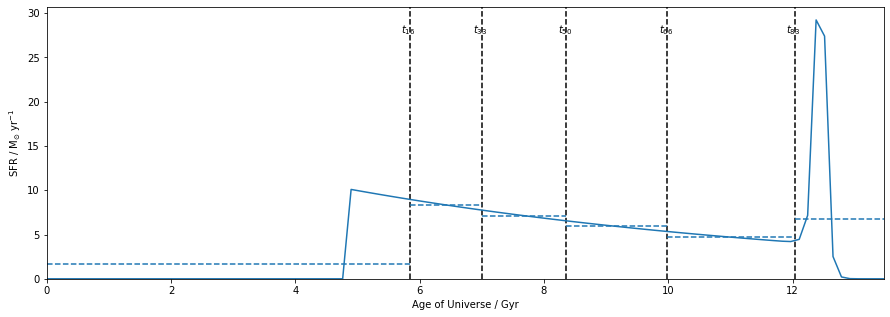

mass = 10.925540225572611
summed squared arror between averaged sfr and actual sfh = 1.5388956719706341


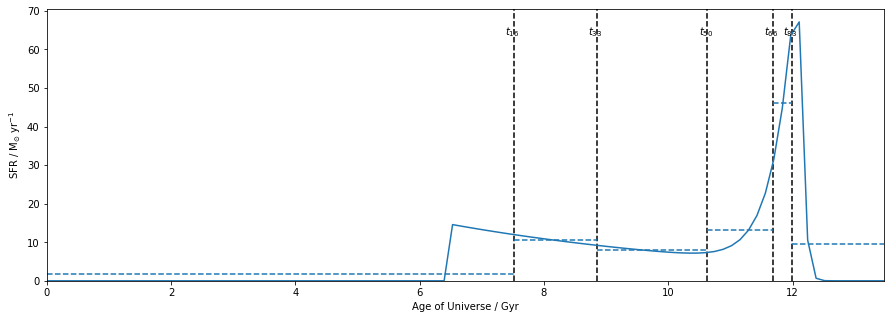

mass = 10.668112869129606
summed squared arror between averaged sfr and actual sfh = 4.344766637751873


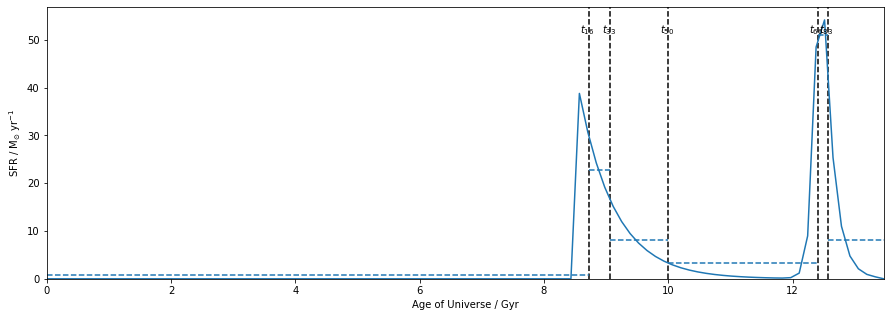

mass = 11.420795258633383
summed squared arror between averaged sfr and actual sfh = 1.988821998821255


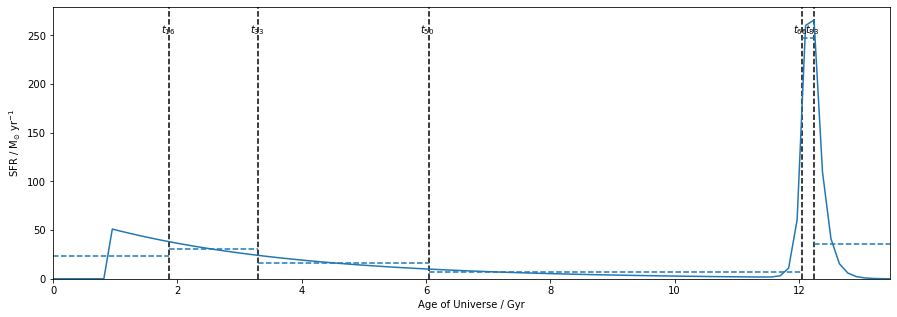

mass = 9.7700772536152
summed squared arror between averaged sfr and actual sfh = 3.958075598970938


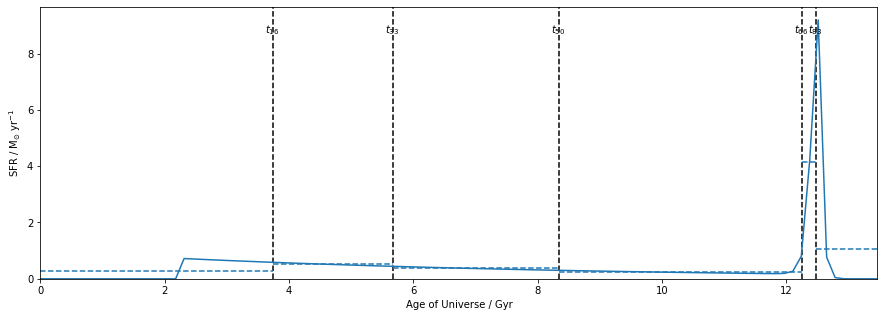

mass = 9.172843500258077
summed squared arror between averaged sfr and actual sfh = 2.0602479369615017


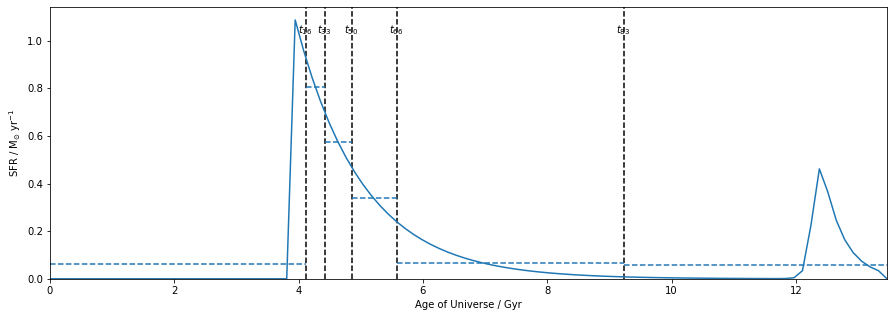

mass = 10.735614228952462
summed squared arror between averaged sfr and actual sfh = 4.21534270566981


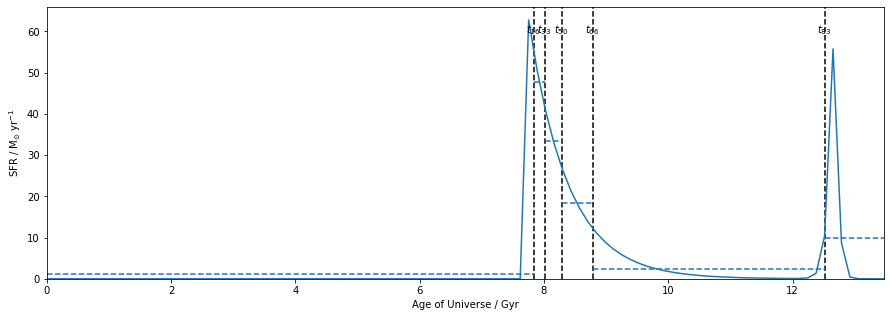

mass = 10.23299378079476
summed squared arror between averaged sfr and actual sfh = 1.0613641938373533


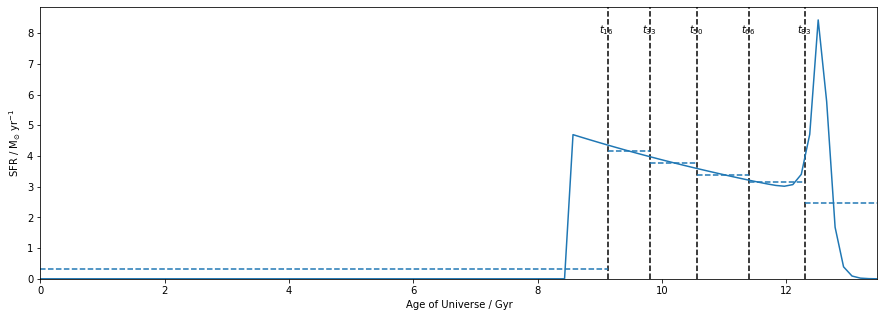

mass = 9.795370942218726
summed squared arror between averaged sfr and actual sfh = 1.4218365200513305


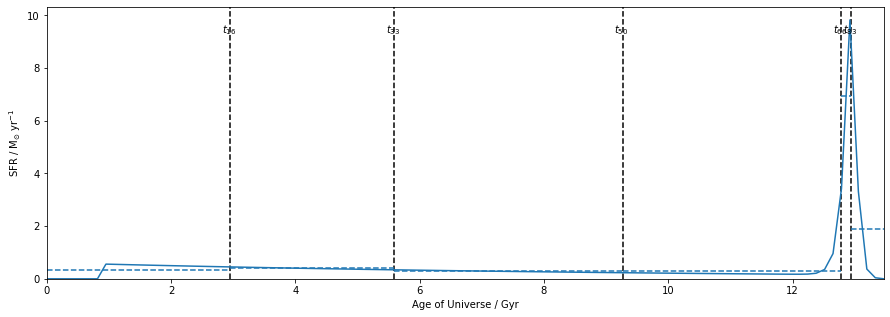

mass = 9.384623404245202
summed squared arror between averaged sfr and actual sfh = 1.203412255664322


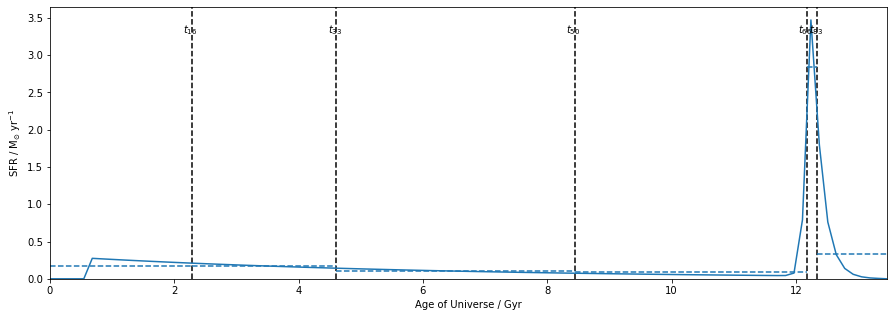

mass = 11.0318552972161
summed squared arror between averaged sfr and actual sfh = 1.0239319144146783


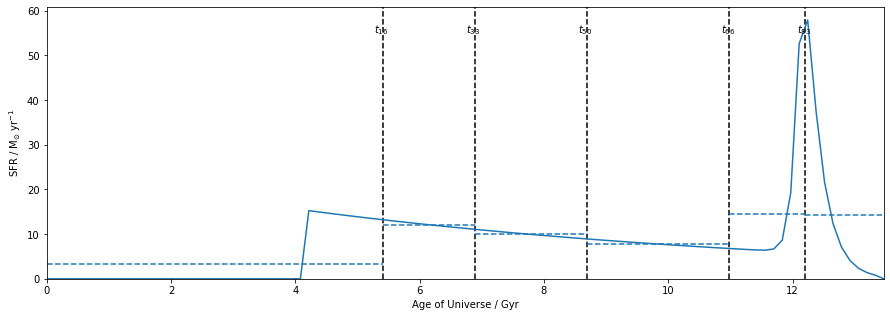

mass = 10.066468042560384
summed squared arror between averaged sfr and actual sfh = 0.876296407136786


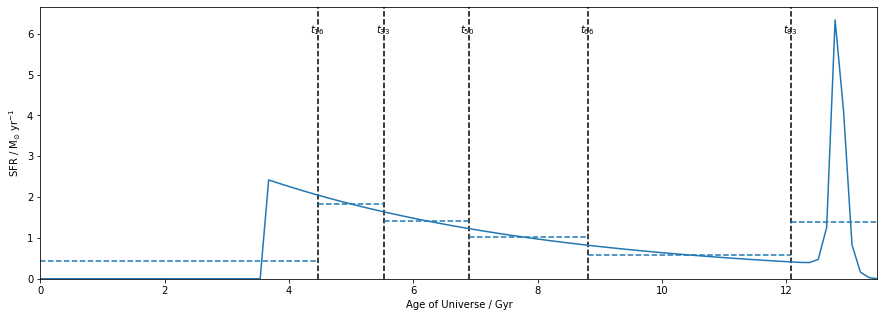

mass = 11.273966107829455
summed squared arror between averaged sfr and actual sfh = 0.5560772344939745


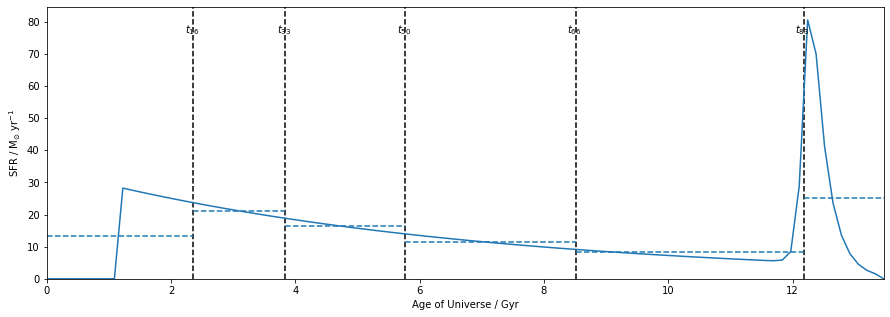

mass = 9.897217490993533
summed squared arror between averaged sfr and actual sfh = 2.7489315593702406


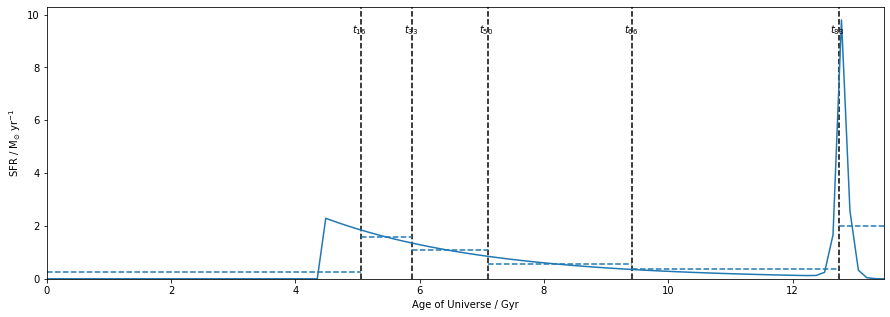

mass = 11.394875352374713
summed squared arror between averaged sfr and actual sfh = 2.1470464932028683


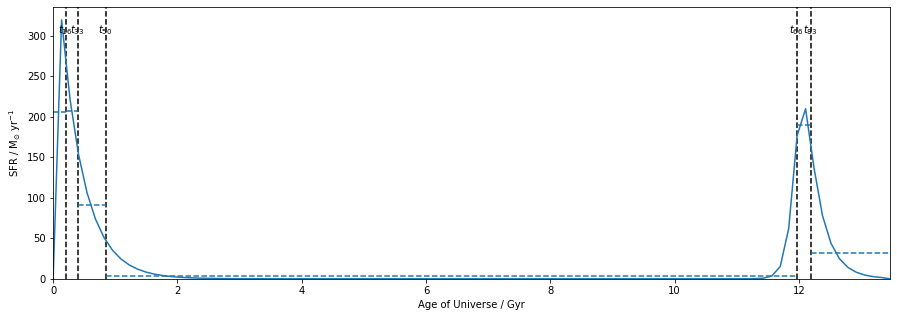

mass = 9.510007641612907
summed squared arror between averaged sfr and actual sfh = 3.4202601429620185


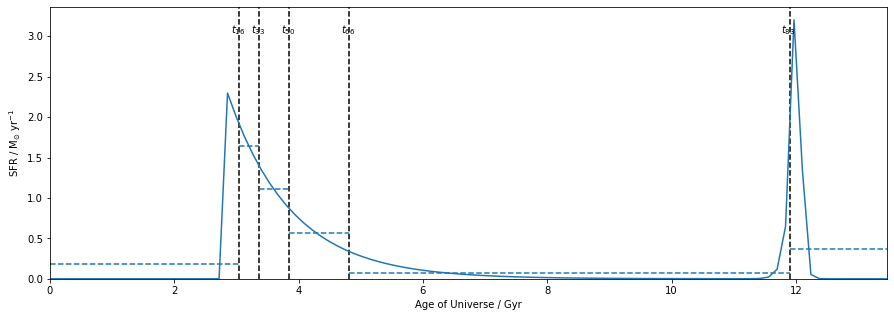

mass = 10.128790714599123
summed squared arror between averaged sfr and actual sfh = 0.22628663563001367


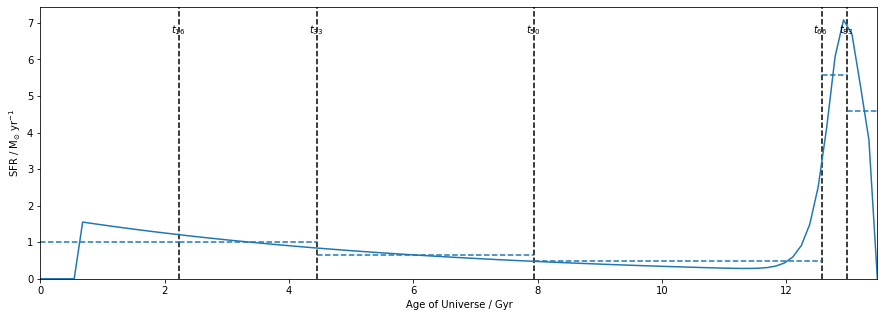

mass = 9.924811424390288
summed squared arror between averaged sfr and actual sfh = 0.6494688907010043


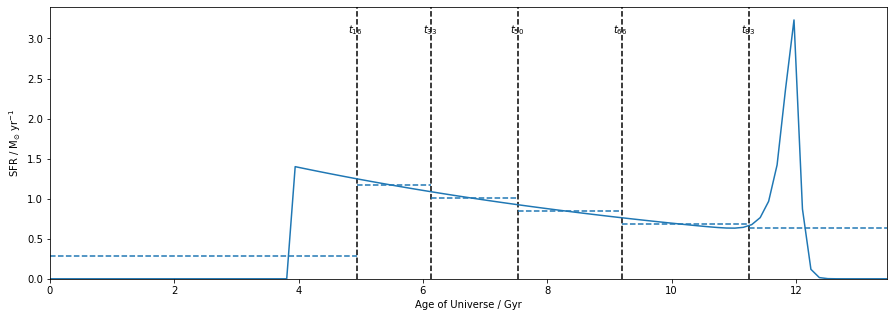

mass = 9.150064075246823
summed squared arror between averaged sfr and actual sfh = 1.4925869816553174


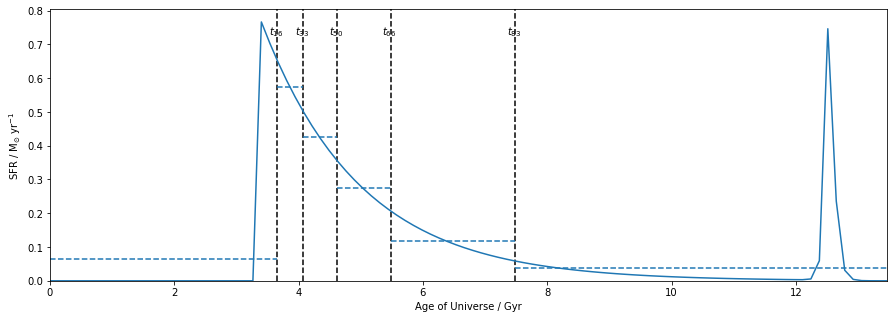

mass = 9.905642549559396
summed squared arror between averaged sfr and actual sfh = 1.8639374979010712


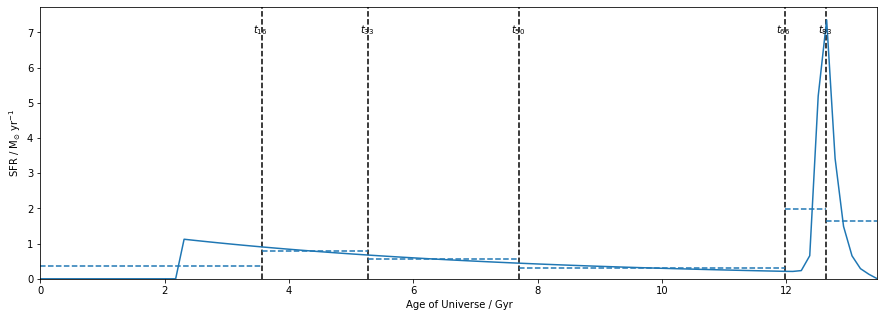

In [114]:
for i,model_sfh in enumerate(SFHs):
    print('mass =',np.log10(Mstars[i]))
    Nbins = 6
    tx = bin_iyer(Nbins)

    fig, ax = plt.subplots(figsize=[15,5])
    p0 = ax.plot(model_ages, model_sfh)
    ax.set_xlim([0,age_at_z])
    ax.set_xlabel('Age of Universe / Gyr')
    ax.set_ylabel(r'SFR / $\rm{M_{\odot}}\; \rm{yr}^{-1}$')
    ylims = ax.get_ylim()
    ax.vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
    for i,txi in enumerate(tx):
        ax.annotate('$t_{'+str(int((i+1)*100/Nbins))+'}$', [(txi-0.01)*age_at_z, 0.95*max(model_sfh)])
    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    print('summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])
    ax.hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin')
    ax.set_ylim([0,ylims[1]])
    plt.show()

In [115]:
iyer_errs_allGal = []
for i,model_sfh in enumerate(SFHs):
    print('fitting galaxy',i+1)
    model_Mstar = Mstars[i]
    iyer_errs = []
    for Nbins in np.arange(2,25):
        iyer_errs.append(do_iyer_fitting(Nbins,vb=False))
    iyer_errs = np.array(iyer_errs).T
    iyer_errs_allGal.append(iyer_errs)
iyer_errs_allGal = np.array(iyer_errs_allGal)

fitting galaxy 1
fitting galaxy 2
fitting galaxy 3
fitting galaxy 4
fitting galaxy 5
fitting galaxy 6
fitting galaxy 7
fitting galaxy 8
fitting galaxy 9
fitting galaxy 10
fitting galaxy 11
fitting galaxy 12
fitting galaxy 13
fitting galaxy 14
fitting galaxy 15
fitting galaxy 16
fitting galaxy 17
fitting galaxy 18
fitting galaxy 19
fitting galaxy 20


Text(0, 0.5, '(fitting) "area error" statistic')

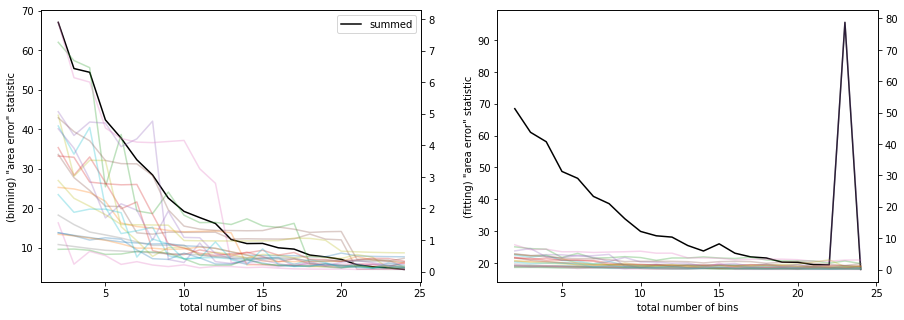

In [116]:
iyer_errs_summed = np.sum(iyer_errs_allGal,axis=0)

fig, ax = plt.subplots(1,2,figsize=[15,5])
ax[0].plot(np.arange(2,25), iyer_errs_summed[0],'k', label='summed')
ax0t = ax[0].twinx()
ax1t = ax[1].twinx()
for i,erri in enumerate(iyer_errs_allGal):
    ax0t.plot(np.arange(2,25), erri[0], label=i, alpha=0.3)
    ax1t.plot(np.arange(2,25), erri[1], label=i, alpha=0.3)
ax[0].legend()
ax[0].set_xlabel('total number of bins')
ax[0].set_ylabel('(binning) "area error" statistic')

ax[1].plot(np.arange(2,25), iyer_errs_summed[1],'k', label='summed')
ax[1].set_xlabel('total number of bins')
ax[1].set_ylabel('(fitting) "area error" statistic')

fitting galaxy 1
fitting galaxy 2
fitting galaxy 3
fitting galaxy 4
fitting galaxy 5
fitting galaxy 6
fitting galaxy 7
fitting galaxy 8
fitting galaxy 9
fitting galaxy 10
fitting galaxy 11
fitting galaxy 12
fitting galaxy 13
fitting galaxy 14
fitting galaxy 15
fitting galaxy 16
fitting galaxy 17
fitting galaxy 18
fitting galaxy 19
fitting galaxy 20


Text(0, 0.5, '(fitting) "area error" statistic')

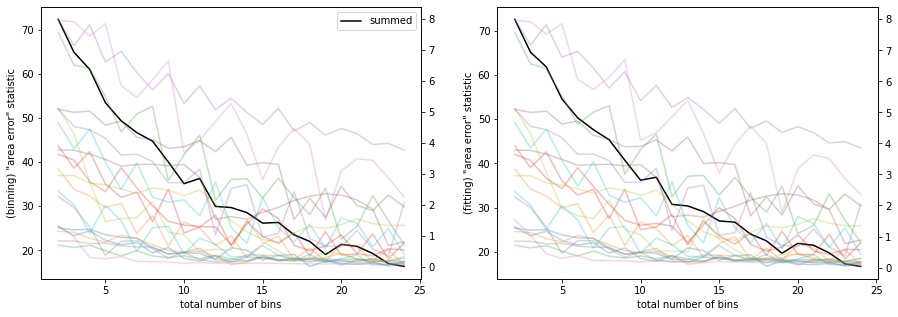

In [117]:
lt_errs_allGal = []
for i,model_sfh in enumerate(SFHs):
    print('fitting galaxy',i+1)
    model_Mstar = Mstars[i]
    lt_errs = []
    for Nbins in np.arange(2,25):
        lt_errs.append(do_lt_fitting(Nbins,vb=False))
    lt_errs = np.array(lt_errs).T
    lt_errs_allGal.append(lt_errs)
lt_errs_allGal = np.array(lt_errs_allGal)

lt_errs_summed = np.sum(lt_errs_allGal,axis=0)

fig, ax = plt.subplots(1,2,figsize=[15,5])
ax[0].plot(np.arange(2,25), lt_errs_summed[0],'k', label='summed')
ax0t = ax[0].twinx()
ax1t = ax[1].twinx()
for i,erri in enumerate(lt_errs_allGal):
    ax0t.plot(np.arange(2,25), erri[0], label=i, alpha=0.3)
    ax1t.plot(np.arange(2,25), erri[1], label=i, alpha=0.3)
ax[0].legend()
ax[0].set_xlabel('total number of bins')
ax[0].set_ylabel('(binning) "area error" statistic')

ax[1].plot(np.arange(2,25), lt_errs_summed[1],'k', label='summed')
ax[1].set_xlabel('total number of bins')
ax[1].set_ylabel('(fitting) "area error" statistic')

In [118]:
iyer_lt_errs2 = []
iyer_lt_bins2 = [[],[],[]]
for Ntotal in np.arange(3,25):
    print(f'fitting for {Ntotal} total bins.')
    for Niyer in np.arange(2,Ntotal):
        Nlt = Ntotal-Niyer+1
        this_error = []
        for i,model_sfh in enumerate(SFHs):
            model_Mstar = Mstars[i]
            this_error.append(do_iyer_lt_fitting([Niyer,Nlt], vb=False))
        iyer_lt_errs2.append(np.sum(np.array(this_error),axis=0))
        iyer_lt_bins2[0].append(Ntotal)
        iyer_lt_bins2[1].append(Niyer)
        iyer_lt_bins2[2].append(Nlt)
iyer_lt_errs2 = np.array(iyer_lt_errs2).T

fitting for 3 total bins.
fitting for 4 total bins.
fitting for 5 total bins.
fitting for 6 total bins.
fitting for 7 total bins.
fitting for 8 total bins.
fitting for 9 total bins.
fitting for 10 total bins.
fitting for 11 total bins.
fitting for 12 total bins.
fitting for 13 total bins.
fitting for 14 total bins.
fitting for 15 total bins.
fitting for 16 total bins.
fitting for 17 total bins.
fitting for 18 total bins.
fitting for 19 total bins.
fitting for 20 total bins.
fitting for 21 total bins.
fitting for 22 total bins.
fitting for 23 total bins.
fitting for 24 total bins.


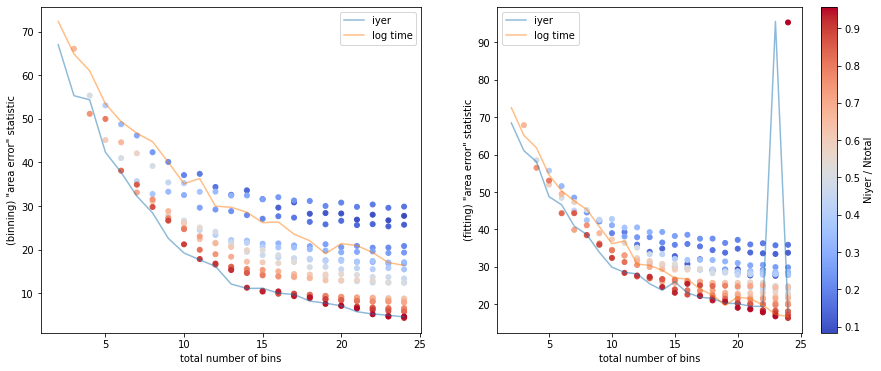

In [124]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
ax[0].plot(np.arange(2,25), iyer_errs_summed[0], label='iyer', alpha=0.5)
ax[0].plot(np.arange(2,25), lt_errs_summed[0], label='log time', alpha=0.5)
s1 = ax[0].scatter(iyer_lt_bins2[0],iyer_lt_errs2[0],c=(np.array(iyer_lt_bins2[1])/np.array(iyer_lt_bins2[0])),
                s=25,cmap='coolwarm')
cbar = fig.colorbar(s1)
cbar.set_label('Niyer / Ntotal')
ax[0].set_xlabel('total number of bins')
ax[0].set_ylabel('(binning) "area error" statistic')
ax[0].legend()

ax[1].plot(np.arange(2,25), iyer_errs_summed[1], label='iyer', alpha=0.5)
ax[1].plot(np.arange(2,25), lt_errs_summed[1], label='log time', alpha=0.5)
s1 = ax[1].scatter(iyer_lt_bins2[0],iyer_lt_errs2[1],c=(np.array(iyer_lt_bins2[1])/np.array(iyer_lt_bins2[0])),
                s=25,cmap='coolwarm')
ax[1].set_xlabel('total number of bins')
ax[1].set_ylabel('(fitting) "area error" statistic')
ax[1].legend()
plt.show()

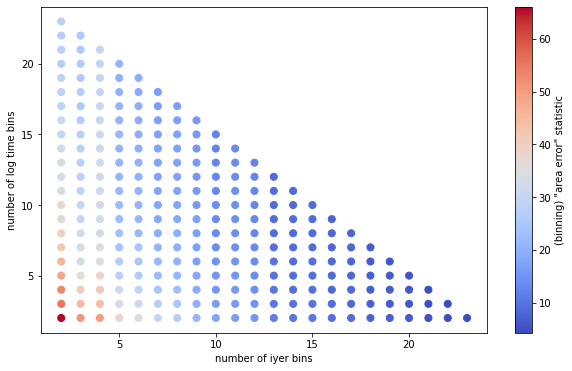

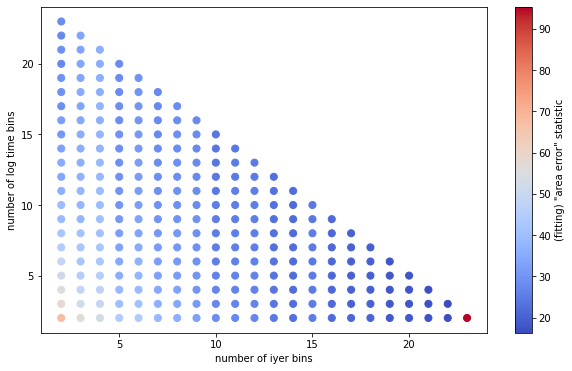

In [120]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
s2 = ax.scatter(iyer_lt_bins2[1],iyer_lt_bins2[2],c=iyer_lt_errs2[0],s=50,cmap='coolwarm')
cbar = fig.colorbar(s2)
cbar.set_label('(binning) "area error" statistic')
ax.set_xlabel('number of iyer bins')
ax.set_ylabel('number of log time bins')
plt.show()

fig, ax = plt.subplots(1,1, figsize=[10,6])
s2 = ax.scatter(iyer_lt_bins2[1],iyer_lt_bins2[2],c=iyer_lt_errs2[1],s=50,cmap='coolwarm')
cbar = fig.colorbar(s2)
cbar.set_label('(fitting) "area error" statistic')
ax.set_xlabel('number of iyer bins')
ax.set_ylabel('number of log time bins')
plt.show()

In [121]:
iyer_iyer_errs2 = []
iyer_iyer_bins2 = [[],[],[]]
for Ntotal in np.arange(3,25):
    print(f'fitting for {Ntotal} total bins.')
    for N1 in np.arange(2,Ntotal):
        N2 = Ntotal-N1+1
        this_error = []
        for i,model_sfh in enumerate(SFHs):
            model_Mstar = Mstars[i]
            this_error.append(do_iyer_iyer_fitting([N1,N2], vb=False))
        iyer_iyer_errs2.append(np.sum(np.array(this_error),axis=0))
        iyer_iyer_bins2[0].append(Ntotal)
        iyer_iyer_bins2[1].append(N1)
        iyer_iyer_bins2[2].append(N2)
iyer_iyer_errs2 = np.array(iyer_iyer_errs2).T

fitting for 3 total bins.
fitting for 4 total bins.
fitting for 5 total bins.
fitting for 6 total bins.
fitting for 7 total bins.
fitting for 8 total bins.
fitting for 9 total bins.
fitting for 10 total bins.
fitting for 11 total bins.
fitting for 12 total bins.
fitting for 13 total bins.
fitting for 14 total bins.
fitting for 15 total bins.
fitting for 16 total bins.
fitting for 17 total bins.
fitting for 18 total bins.
fitting for 19 total bins.
fitting for 20 total bins.
fitting for 21 total bins.
fitting for 22 total bins.
fitting for 23 total bins.
fitting for 24 total bins.


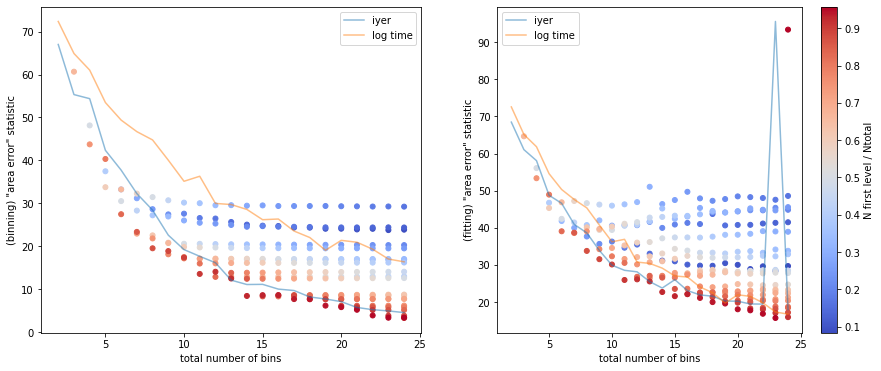

In [125]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
ax[0].plot(np.arange(2,25), iyer_errs_summed[0], label='iyer', alpha=0.5)
ax[0].plot(np.arange(2,25), lt_errs_summed[0], label='log time', alpha=0.5)
s1 = ax[0].scatter(iyer_iyer_bins2[0],iyer_iyer_errs2[0],c=(np.array(iyer_iyer_bins2[1])/np.array(iyer_iyer_bins2[0])),
                s=25,cmap='coolwarm')
cbar = fig.colorbar(s1)
cbar.set_label('N first level / Ntotal')
ax[0].set_xlabel('total number of bins')
ax[0].set_ylabel('(binning) "area error" statistic')
ax[0].legend()

ax[1].plot(np.arange(2,25), iyer_errs_summed[1], label='iyer', alpha=0.5)
ax[1].plot(np.arange(2,25), lt_errs_summed[1], label='log time', alpha=0.5)
s1 = ax[1].scatter(iyer_iyer_bins2[0],iyer_iyer_errs2[1],c=(np.array(iyer_iyer_bins2[1])/np.array(iyer_iyer_bins2[0])),
                s=25,cmap='coolwarm')
ax[1].set_xlabel('total number of bins')
ax[1].set_ylabel('(fitting) "area error" statistic')
ax[1].legend()
plt.show()

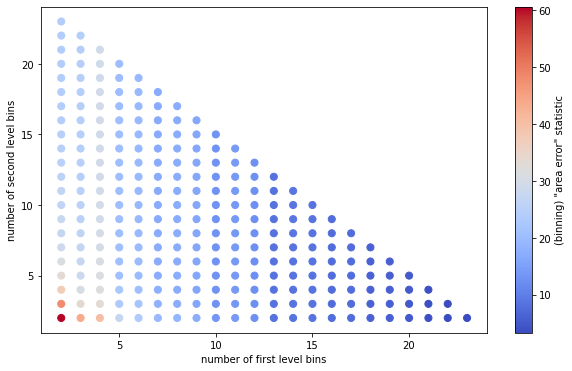

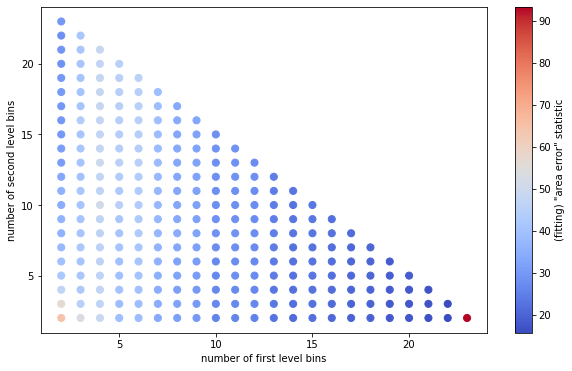

In [123]:
fig, ax = plt.subplots(1,1, figsize=[10,6])
s2 = ax.scatter(iyer_iyer_bins2[1],iyer_iyer_bins2[2],c=iyer_iyer_errs2[0],s=50,cmap='coolwarm')
cbar = fig.colorbar(s2)
cbar.set_label('(binning) "area error" statistic')
ax.set_xlabel('number of first level bins')
ax.set_ylabel('number of second level bins')
plt.show()

fig, ax = plt.subplots(1,1, figsize=[10,6])
s2 = ax.scatter(iyer_iyer_bins2[1],iyer_iyer_bins2[2],c=iyer_iyer_errs2[1],s=50,cmap='coolwarm')
cbar = fig.colorbar(s2)
cbar.set_label('(fitting) "area error" statistic')
ax.set_xlabel('number of first level bins')
ax.set_ylabel('number of second level bins')
plt.show()